In [3]:
#K-Means ile Müşteri Segmentasyonu

#İş Problemi: Kural tabanlı müşteri segmentasyonu yöntemi RFM ile makine öğrenmesi yöntemi olan K-Means'in müşteri 
#segmentasyonu için karşılaştırılması beklenmektedir.

#Veri Seti Hikayesi: Online Retail II isimli veri seti İngiltere merkezli bir perakende şirketinin 01/12/2009 - 09/12/2011 
#tarihleri arasındaki online satış işlemlerini içeriyor. 
#Şirketin ürün kataloğunda hediyelik eşyalar yer almaktadır ve çoğu müşterisinin toptancı olduğu bilgisi mevcuttur

#InvoiceNo: Fatura Numarası ( Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder )
#StockCode: Ürün kodu ( Her bir ürün için eşsiz )
#Description: Ürün ismi
#Quantity: Ürün adedi ( Faturalardaki ürünlerden kaçar tane satıldığı)
#InvoiceDate: Fatura tarihi
#UnitPrice: Fatura fiyatı ( Sterlin )
#CustomerID: Eşsiz müşteri numarası
#Country: Ülke ismi

#Görev: RFM metriklerine göre (skorlar değil) K-Means'i kullanarak müşteri segmentasyonu yapınız.
#Dilerseniz RFM metriklerinden başka metrikler de üretebilir ve bunları da kümeleme için kullanabilirsiniz

In [4]:
import pandas as pd
from scipy import stats
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import numpy as np
import warnings

In [5]:
pd.set_option ('display.max_columns', 50)
pd.set_option ('display.max_rows', 50)
pd.set_option ('display.float_format', lambda x: '%.2f' % x)
pd.set_option ('display.width', 1000)
warnings.filterwarnings ("ignore")

In [6]:
df_ = pd.read_excel ("OneDrive/Masaüstü/müşteri segmentasyon projesi/online_retail_II-230817-120704.xlsx", 
                     sheet_name="Year 2009-2010")

In [7]:
df_

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.00,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.00,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.00,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.00,United Kingdom
...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.00,United Kingdom
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.00,United Kingdom
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.00,United Kingdom


In [8]:
df = df_.copy ()

In [9]:
def check_data(dataframe, head=5):
    print ("####### SHAPE #######")
    print (dataframe.shape)
    print ("####### INFO #######")
    print (dataframe.info ())
    print ("####### DESCRIBE #######")
    print (dataframe.describe ([0.01, 0.1, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]))
    print ("####### NA VALUES #######")
    print (dataframe.isnull ().sum ())
    print ("####### FIRST {} ROWS #######".format (head))
    print (dataframe.head (head))

In [10]:
#ilgili ülkeyi seçmek için bir fonksiyon

def select_country(dataframe, country):
    new_dataframe = dataframe.loc[dataframe["Country"] == country]
    return new_dataframe

In [11]:
#low limit ve up limit belirlediğimiz fonksiyon

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile (q1)
    quartile3 = dataframe[col_name].quantile (q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [12]:
#aykırı değer var mı kontrolü

def check_outlier(dataframe, col_name, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds (dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any (axis=None):
        return True
    else:
        return False

In [13]:
#aykırı değerleri low limit/up limit ile değiştirme

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds (dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [14]:
check_data(df)

####### SHAPE #######
(525461, 8)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB
None
####### DESCRIBE #######
       Quantity                    InvoiceDate     Price  Customer ID
count 525461.00                         525461 525461.00    417534.00
mean      10.34  2010-06-28 11:37:36.845017856      4.69     15360.65
min    -9600.

In [15]:
df = df[~df["Invoice"].str.contains ("C", na=False)]

#InvoiceNo: Fatura Numarası ( Eğer bu kod C ile başlıyorsa işlemin iptal edildiğini ifade eder )
#o yüzden bunları veriden çıkarıyoruz
#aykırılıkların da önüne geçmeyi hedefliyoruz bu şekilde

In [16]:
df = df[(df['Quantity'] > 0)]

#Quantity: Ürün adedi ( Faturalardaki ürünlerden kaçar tane satıldığı)
#bazı değerlerin "-" li olduğunu görmüştük, bu yüzden 0dan büyük olanları alıyoruz
#yine aykırılıklardan uzaklaşmayı hedefliyoruz

In [17]:
df.dropna (inplace=True)

#boş değerleri atmayı tercih ediyoruz Description ve Customer Id değişkenlerinde var

In [18]:
#tekrar describeına bakalım

df.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,InvoiceDate,Price,Customer ID
count,407695.00,407695,407695.00,407695.00
mean,13.59,2010-07-01 10:10:10.782177792,3.29,15368.50
min,1.00,2009-12-01 07:45:00,0.00,12346.00
1%,1.00,2009-12-02 15:10:00,0.29,12435.00
10%,1.00,2010-01-19 11:01:00,0.65,13044.00
25%,2.00,2010-03-26 14:01:00,1.25,13997.00
50%,5.00,2010-07-09 15:46:00,1.95,15321.00
75%,12.00,2010-10-14 17:09:00,3.75,16812.00
90%,24.00,2010-11-18 10:37:00,6.75,17706.00
99%,144.00,2010-12-07 14:31:00,14.95,18196.00


In [19]:
df[df["Price"] == 0]["StockCode"].unique ()
#uniq değerlere bakalım

#StockCode: Ürün kodu ( Her bir ürün için eşsiz )

#çıktı: ürünlerin stok kodları
#"M" isminde bir stok kod varmış bunun ne olduğunu bilmiyoruz, diğer kodlardan ayrıştığını da görebiliyoruz

array([22076, 48185, 'M', 22065, 22142, 85042, 21143, 79320, 22355, 21533,
       'TEST001', 21662, 22459, 22458, 22376, 21765, 20914, 22423, 22690,
       22472, 22202, '46000M', 22218, 22630, 22121, 21843, 22624, 22846,
       22845, 22841], dtype=object)

In [20]:
df = df[df["StockCode"] != "M"]

#burada bu "M" değerini atıyoruz

In [21]:
#üstteki çıktıda "TEST001" diye bir değer gördük bunun ne anlama geldiğini bilmiyoruz
#bu tarz başka değerler var mı diye bakalım

invalid_codes = df[df["StockCode"].astype (str).str.contains (r"[a-zA-Z]{3,}")]["StockCode"].unique ().tolist ()
invalid_codes

['POST', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'ADJUST2']

In [22]:
#bu belirsiz dediğimiz değerler için bazı gözlemler yapalım

df[df["StockCode"].isin (invalid_codes)].groupby (["StockCode"]).agg ({"Invoice": "nunique",
                                                                       "Quantity": "sum",
                                                                       "Price": "sum",
                                                                       "Customer ID": "nunique"})

#çıktı:
#görüyoruz ki bunların çoğunluğunu "POST" isimli stok kodu oluşturuyor, kargoyla alakalı olabilir diye bir yorum yapılabilir
#diğer stok kodları POST ile kıyasladığımız zaman diğerlerini rare değişken olarak sınıflandırabiliriz (yorum)
#pricelarına baktığımızda PADS'te yaklaşık 0 bir price var bu da değişik olabilir

,Invoice,Quantity,Price,Customer ID
StockCode,,,,
ADJUST,32,32,3538.52,25
ADJUST2,3,3,731.05,3
BANK CHARGES,20,20,300.00,12
PADS,14,14,0.01,12
POST,738,2212,19964.83,230
TEST001,11,60,40.50,4
TEST002,1,1,1.00,1


In [23]:
#yine bunları verisetinden çıkarmayı tercih edelim (yanlılığı azaltmayı hedefliyoruz)

df = df[~df["StockCode"].isin (invalid_codes)].reset_index (drop=True)

In [24]:
check_data (df)

####### SHAPE #######
(406450, 8)
####### INFO #######
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406450 entries, 0 to 406449
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      406450 non-null  object        
 1   StockCode    406450 non-null  object        
 2   Description  406450 non-null  object        
 3   Quantity     406450 non-null  int64         
 4   InvoiceDate  406450 non-null  datetime64[ns]
 5   Price        406450 non-null  float64       
 6   Customer ID  406450 non-null  float64       
 7   Country      406450 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 24.8+ MB
None
####### DESCRIBE #######
       Quantity                    InvoiceDate     Price  Customer ID
count 406450.00                         406450 406450.00    406450.00
mean      13.62  2010-07-01 10:28:27.142084608      3.01     15373.48
min        1.

In [25]:
#rfm metriklerini hesaplamak için ne gibi değerlere ihtiyacımız vardı?

#Recency (Tazelik): Bu metrik, müşterinin son alışverişini ne zaman yaptığını ifade eder. 
#Frequency (Sıklık): Bu metrik, müşterinin belirli bir zaman diliminde kaç kez alışveriş yaptığını ifade eder. 
#Monetary (Mali Değer): Bu metrik, müşterinin belirli bir zaman diliminde harcadığı toplam miktarı ifade eder. 

In [26]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [27]:
df.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Quantity,InvoiceDate,Price,Customer ID,TotalPrice
count,406450.00,406450,406450.00,406450.00,406450.00
mean,13.62,2010-07-01 10:28:27.142084608,3.01,15373.48,21.36
min,1.00,2009-12-01 07:45:00,0.00,12346.00,0.00
1%,1.00,2009-12-02 15:04:00,0.29,12437.00,0.65
10%,1.00,2010-01-19 10:41:00,0.65,13050.00,2.10
25%,2.00,2010-03-26 14:01:00,1.25,14006.00,4.95
50%,5.00,2010-07-09 15:48:00,1.95,15325.00,11.85
75%,12.00,2010-10-14 17:09:00,3.75,16814.00,19.50
90%,24.00,2010-11-18 10:37:00,6.75,17706.00,35.40
99%,144.00,2010-12-07 14:31:00,12.75,18196.00,197.10


In [29]:
max_invoice_date = df["InvoiceDate"].max ()

#InvoiceDate: Fatura tarihi
#en son alışveriş yaptığı tarihi göreceğiz

max_invoice_date

Timestamp('2010-12-09 20:01:00')

In [30]:
#metrik olarak invoice_date'in max'ını kullanamayız
#günümüz tarihinden 2 gün sonrayı alalım ki verisetinde 0 değer olmasın

today_date = (max_invoice_date + dt.timedelta (days=2))

In [33]:
#şimdi müşteri bazlı rfm metriğini çıkarabiliriz
#invoice: frekans

rfm = df.groupby ("Customer ID").agg ({"InvoiceDate": lambda date: (today_date - date.max ()).days,
                                       "Invoice": "nunique",
                                       "TotalPrice": "sum"})

rfm.head()

,InvoiceDate,Invoice,TotalPrice
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [34]:
rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()

,Recency,Frequency,Monetary
Customer ID,,,
12346.00,166,2,169.36
12347.00,4,2,1323.32
12348.00,75,1,221.16
12349.00,44,2,2221.14
12351.00,12,1,300.93


In [35]:
#verisetine daha önce baktığımızda bize bıraktığı para/alışveriş sıklığı 0 olan değerler vardı
#bunları analiz etmek istemeyiz çünkü bir şey ifade etmiyor, bunlara bir segmentleme yapmaya ihtiyaç duymayız

#bu yüzden bu aykırı değerleri ayıklama işlemi yapalım

rfm = rfm[(rfm["Monetary"]) > 0 & (rfm["Frequency"] > 0)]

In [36]:
rfm.describe ([0.01, 0.1, 0.25, 0.5, 0.75, 0.90, 0.99])

,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.43,2025.18
std,96.35,7.95,8829.91
min,2.00,1.00,1.55
1%,2.00,1.00,40.76
10%,9.00,1.00,157.03
25%,19.00,1.00,307.66
50%,53.00,2.00,702.25
75%,136.75,5.00,1703.98
90%,255.00,9.00,3761.56


In [37]:
#aykırı değer kontrolü

for col in rfm.columns:
    print (col, check_outlier (rfm, col))

Recency False
Frequency True
Monetary True


In [38]:
#aykırı değerleri baskılama

for col in rfm.columns:
    replace_with_thresholds (rfm, col)

In [40]:
rfm.describe()

,Recency,Frequency,Monetary
count,4286.00,4286.00,4286.00
mean,91.56,4.11,1588.58
std,96.35,4.89,2523.16
min,2.00,1.00,1.55
25%,19.00,1.00,307.66
50%,53.00,2.00,702.25
75%,136.75,5.00,1703.98
max,375.00,31.00,15243.20


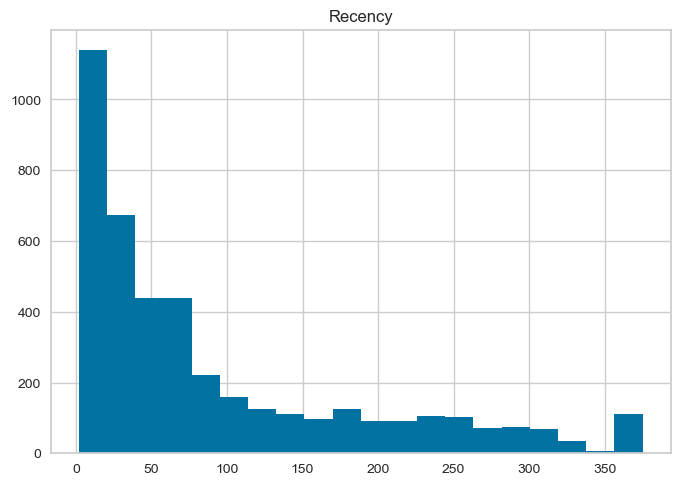

In [41]:
#görselleştirme 

rfm["Recency"].hist (bins=20)
plt.title ("Recency")
plt.show ()

#recency değerinin daha çok 0 ile 50 arasına yığıldığını görüyoruz
#baktığımızda normal dağılıma uymuyor, çarpıklık söz konusu diyebiliriz

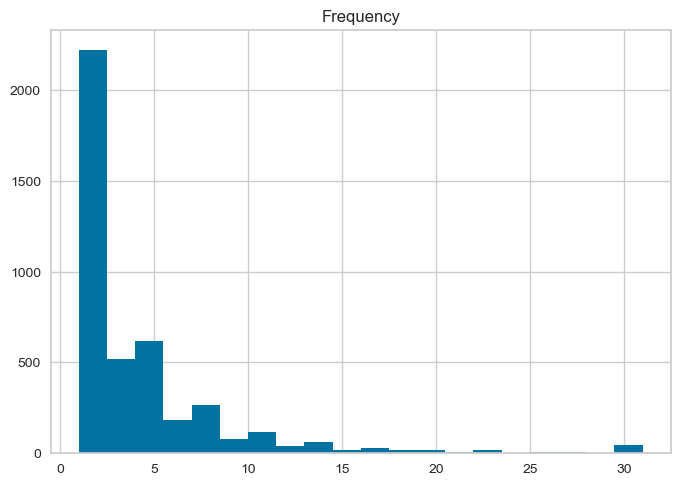

In [42]:
rfm["Frequency"].hist (bins=20)
plt.title ("Frequency")
plt.show ()

#aynı şekilde çarpıklık söz konusu

In [43]:
#monetary tarafı yorum yapmak için kullanılır

In [44]:
#recency ve frequency'i normale yaklaştırmak için LOG TRANSFORMATION kullanacağız

# LOG TRANSFORMATION
for col in ["Recency", "Frequency"]:
    rfm[f"LOG_{col}"] = np.log1p (rfm[col])
rfm.head ()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency
Customer ID,,,,,
12346.00,166.00,2,169.36,5.12,1.10
12347.00,4.00,2,1323.32,1.61,1.10
12348.00,75.00,1,221.16,4.33,0.69
12349.00,44.00,2,2221.14,3.81,1.10
12351.00,12.00,1,300.93,2.56,0.69


In [46]:
#standartlaştırmamız gerekiyor

# SCALER
sc = StandardScaler ()
sc.fit (rfm[["LOG_Recency", "LOG_Frequency"]])
scaled_rf = sc.transform (rfm[["LOG_Recency", "LOG_Frequency"]])

In [47]:
scaled_df = pd.DataFrame (index=rfm.index, columns=["LOG_Recency", "LOG_Frequency"], data=scaled_rf)
scaled_df

,LOG_Recency,LOG_Frequency
Customer ID,,
12346.00,0.99,-0.40
12347.00,-1.85,-0.40
12348.00,0.35,-1.00
12349.00,-0.07,-0.40
12351.00,-1.08,-1.00
...,...,...
18283.00,-0.73,0.87
18284.00,0.27,-1.00
18285.00,1.45,-1.00


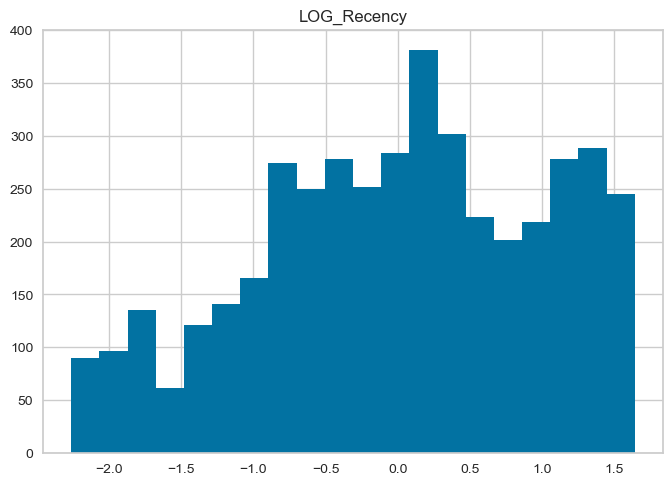

In [48]:
scaled_df["LOG_Recency"].hist(bins=20)
plt.title("LOG_Recency")
plt.show()

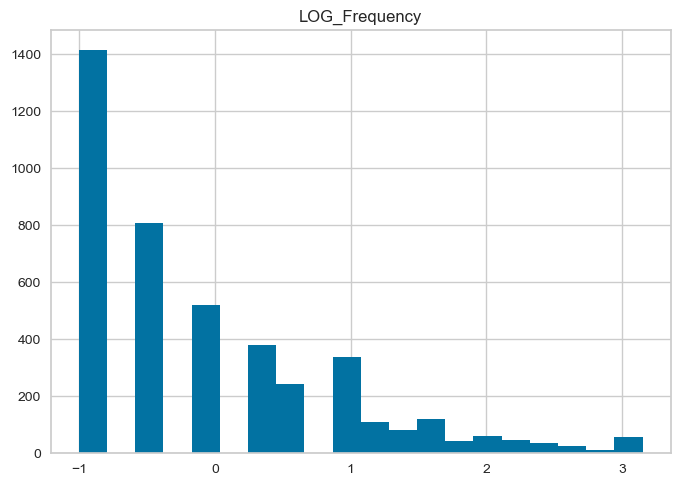

In [49]:
scaled_df["LOG_Frequency"].hist(bins=20)
plt.title("LOG_Frequency")
plt.show()

In [50]:
# Determining Optimal Numbers of Cluster
kmeans = KMeans ()

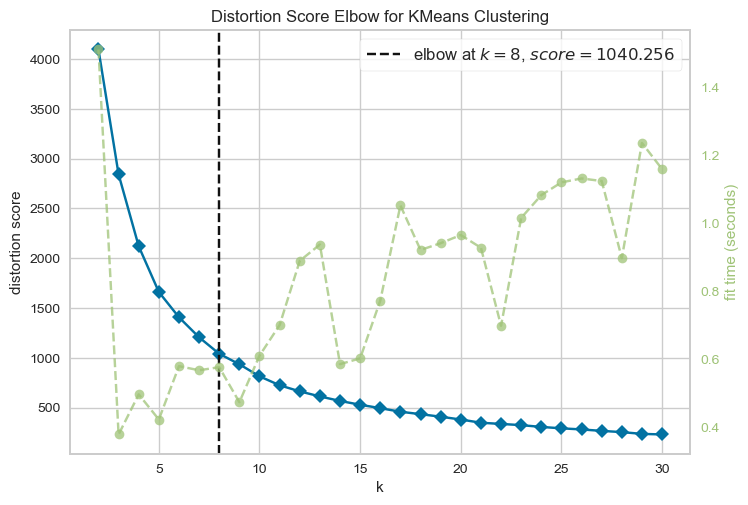

In [51]:
elbow = KElbowVisualizer (kmeans, k=30)
elbow.fit (scaled_df)
elbow.show ();

In [52]:
#elbow'a göre bizim 8 sınıfa ayırmamızı önermiş

k_ = elbow.elbow_value_
print (k_)

8


In [57]:
# K-Means
k_means = KMeans (n_clusters=k_, random_state=99).fit (scaled_df)

#8 sınıfa göre oluşturduğumuz dataframe'imizi fit ediyoruz
#ki bunların aslında her bir unique müşteri belli bir sınıfa göre segmentlere atılsın

In [58]:
segments = k_means.labels_
segments

array([5, 7, 0, ..., 5, 0, 1])

In [59]:
#segmentleri atadık şimdi değişken olarak ekleyelim

rfm["KMeans_Segments"] = segments

rfm.head()

,Recency,Frequency,Monetary,LOG_Recency,LOG_Frequency,KMeans_Segments
Customer ID,,,,,,
12346.00,166.00,2,169.36,5.12,1.10,5
12347.00,4.00,2,1323.32,1.61,1.10,7
12348.00,75.00,1,221.16,4.33,0.69,0
12349.00,44.00,2,2221.14,3.81,1.10,0
12351.00,12.00,1,300.93,2.56,0.69,4


In [60]:
rfm.groupby ("KMeans_Segments").agg ({"Recency": ["mean", "median", "count"],
                                      "Frequency": ["mean", "median", "count"],
                                      "Monetary": ["mean", "median", "count"]})

#segmentlere göre gruplayalım her segmentin recency frequency monetary için mean median count değerlerini görelim

Recency              Frequency              Monetary              
                   mean median count      mean median count     mean  median count
KMeans_Segments                                                                   
0                 69.79  66.00   797      1.44   1.00   797   535.69  380.52   797
1                 26.28  25.00   540      4.10   4.00   540  1545.30 1167.30   540
2                  6.11   5.00   215     19.26  17.00   215  7835.58 6009.34   215
3                110.73  88.50   624      4.16   4.00   624  1681.16 1243.82   624
4                 20.11  20.00   474      1.47   1.00   474   506.44  350.01   474
5                243.24 235.00   939      1.25   1.00   939   401.59  266.60   939
6                 32.15  25.00   390     10.32   9.00   390  4149.67 3119.03   390
7                  5.63   5.00   307      5.29   5.00   307  1882.82 1475.77   307

In [61]:
#mesela monetary değişkeninin 1 ve 3 segmentleri birbirine çok yakın, belki bunları birleştirme yoluna gidilebilir
#ama sadece monetary değerine bakarak bun yorumu yapamayız
#frequency de benzer, recency'e baktığımızda birbirinden farklı olduğu noktaları görüyoruz

#mesela 2. segment için en iyi müşteri denilebilir 
#5. segment kayıp müşteri olarak sınıflandırılabilir

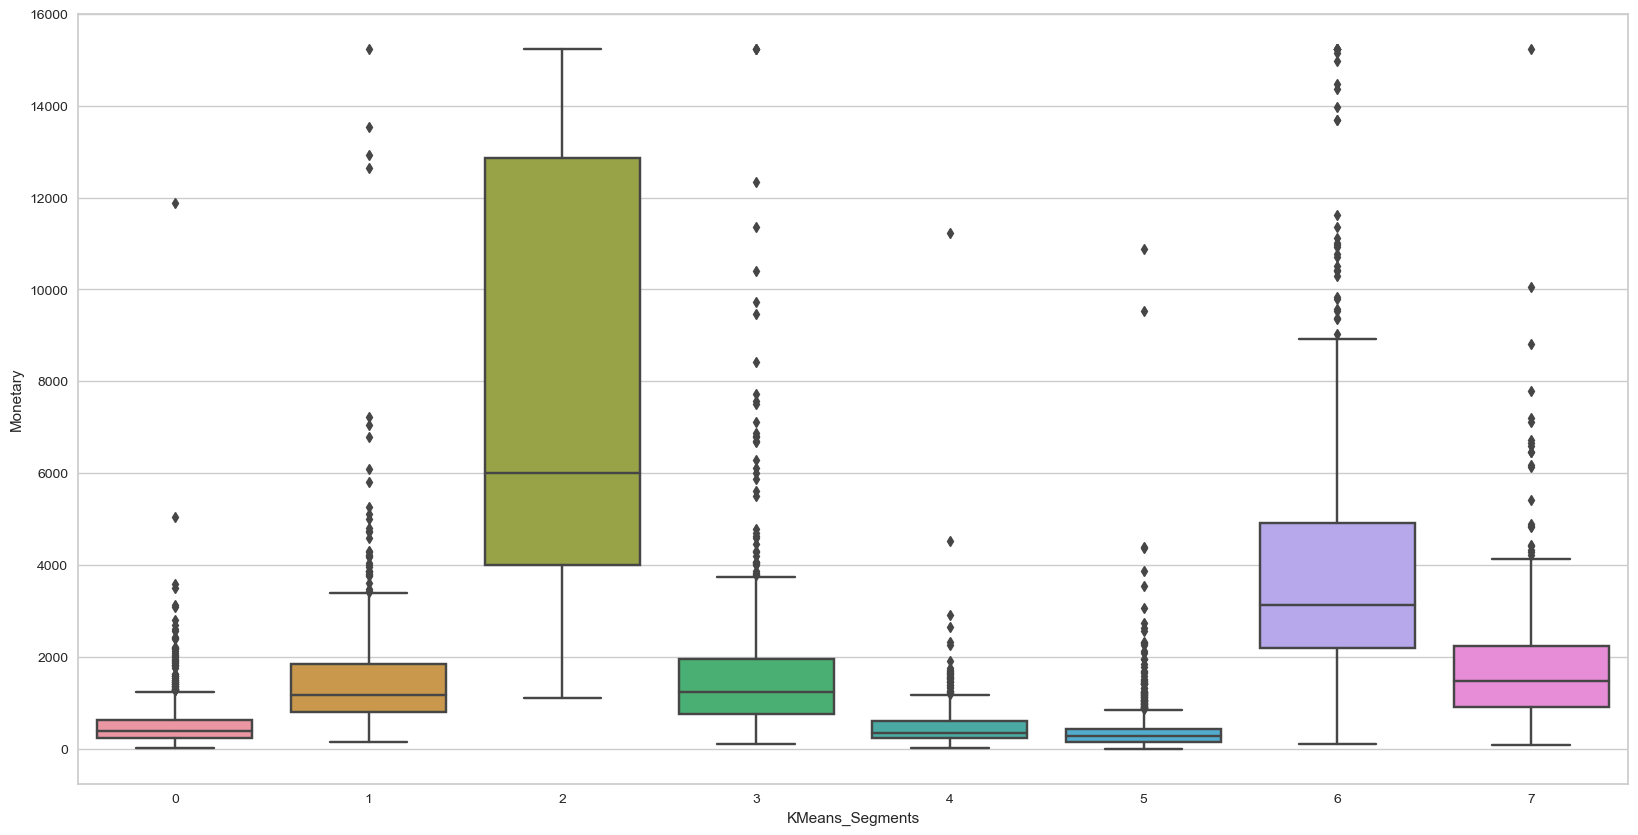

In [62]:
#görselleştirelim 

plt.figure (figsize=(20, 10))
sns.boxplot (x="KMeans_Segments", y="Monetary", data=rfm)
plt.show ();

In [63]:
#monetary üzerinden baktığımızda 0, 4,5 in bize bıraktığı para aynı, diğer değerler de incelenmeli
#bu tarz incelemeler yapılmalı

In [66]:
#8 sınıfa ayır dedi ama biz bir de hiyerarşik kümeleme yapalım

# Hierarchical Clustering

hc_complete = linkage (scaled_df, 'complete')

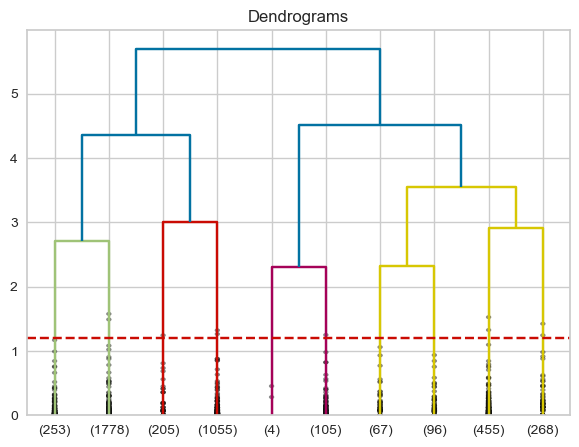

In [67]:
#dendogramına bakalım

plt.figure (figsize=(7, 5))
plt.title ("Dendrograms")
dend = dendrogram (hc_complete,
                   truncate_mode="lastp",
                   p=10,
                   show_contracted=True,
                   leaf_font_size=10)
plt.axhline (y=1.2, color='r', linestyle='--')
plt.show ()

#10 sınıfa ayırmış

In [69]:
#biz 6 sınıfa ayıralım

hc = AgglomerativeClustering (n_clusters=6)

In [70]:
#segmentleri çıkaralım

segments = hc.fit_predict (scaled_df)

In [71]:
#segmentleri kaydedelim

rfm["Hierarchi_Segments"] = segments

In [72]:
rfm.groupby ("Hierarchi_Segments").agg ({"Recency": ["mean", "median", "count"],
                                         "Frequency": ["mean", "median", "count"],
                                         "Monetary": ["mean", "median", "count"]})

Recency              Frequency              Monetary              
                      mean median count      mean median count     mean  median count
Hierarchi_Segments                                                                   
0                    22.54  17.00   915      8.22   7.00   915  3183.45 2342.57   915
1                    71.59  60.00  1091      3.42   3.00  1091  1354.29  940.86  1091
2                   227.53 220.00  1131      1.43   1.00  1131   474.46  301.65  1131
3                    13.24  13.00   462      2.05   2.00   462   654.60  498.73   462
4                    55.18  53.50   534      1.00   1.00   534   413.07  281.32   534
5                     5.11   5.00   153     21.38  19.00   153  8880.06 7637.56   153

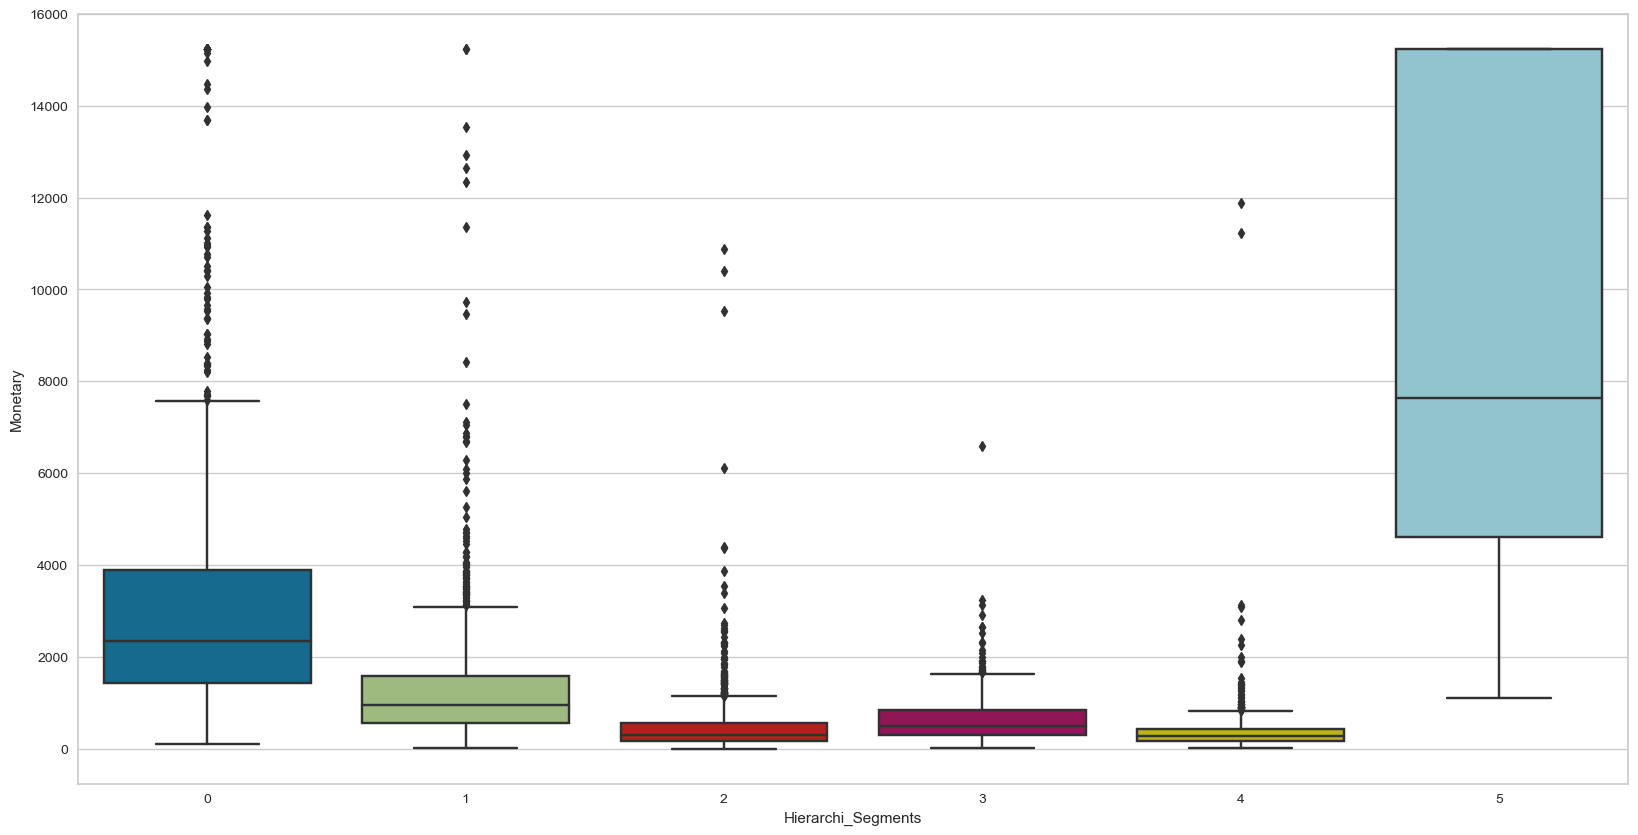

In [73]:
#grafik üzerinden yorumlama yapalım

plt.figure (figsize=(20, 10))
sns.boxplot (x="Hierarchi_Segments", y="Monetary", data=rfm)
plt.show ();